# Teapot Dome Recommender System and Analysis

In [1]:
from colorsys import hsv_to_rgb
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [2]:
%matplotlib inline

First we need to define a few functions

In [3]:
def sample_splitter(dataframe, fraction, randomseed):
    """
    Splits a dataframe into train and test subsets
    :param dataframe: Tops dataframe
    :param fraction: The fraction of tops to use for validation
    :param randomseed: The random seed for random sampling
    :return: training and testing dataframes
    """
    test = dataframe.sample(frac=fraction, random_state=randomseed)
    test_idx = test.index.values
    train = dataframe.drop(test_idx)
    return train, test


# ALS factorization modified from
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return: users, items from ALS
    """
    n, m = A.shape
    np.random.seed(86)
    Users = 5 * np.random.rand(n, n_factors,)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MAE_List = []

    print("Starting Iterations")
    for iteration in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
        MAE_List.append(get_error(A, Users, Items, R))
    return Users, Items


def cross_validation(dataframe, random_seed, latent_vectors, n_iters, reg):
    """
    Splits a dataframe into 4 different folds for cross validation
    :param dataframe: Tops dataframe
    :param random_seed: The random seed for random sampling
    :param latent_vectors: Number of latent vectors for matrix factorization
    :param n_iters: Number of iterations to run ALS
    :param reg: Lamda regularization value
    :return: dataframe with predictions and MAE error
    """
    full = []
    block_1 = dataframe.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    bk = 1
    for block in blocks:
        print(f"Starting Block {bk}")
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f"Validating on {block.shape[0]} tops")
        D_df = main_group.pivot_table("SS", "Formation", "API").fillna(
            0
        )  # pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R)

        U, Vt = runALS(R, A, latent_vectors, n_iters, reg)

        recommendations = np.dot(U, Vt)  # get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        )  # results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(
            validate,
            flat_preds,
            how="left",
            left_on=["API", "Formation"],
            right_on=["API", "Formation"],
        )

        new_df.rename(columns={0: "SS_pred"}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF["signed_error"] = cleanDF["SS"] - cleanDF["SS_pred"]
        cleanDF["Block"] = [bk] * cleanDF.shape[0]
        well_locs.rename(columns={"API Number": "API"}, inplace=True)

        full.append(cleanDF.merge(well_locs[["Northing", "Easting", "API"]], on="API"))
        CV_MAE.append(MAE(cleanDF.SS.values - ssmin, cleanDF.SS_pred.values - ssmin))
        bk += 1
    output = pd.concat(full)
    return output


def cross_validation_error(dataframe, random_seed, latent_vectors, n_iters, reg):
    """
    Splits a dataframe into 4 different folds for cross validation MAE and RMSE
    :param dataframe: Tops dataframe
    :param random_seed: The random seed for random sampling
    :param latent_vectors: Number of latent vectors for matrix factorization
    :param n_iters: Number of iterations to run ALS
    :param reg: Lamda regularization value
    :return: MAE and RMSE error values for each fold
    """
    full = []
    block_1 = dataframe.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    CV_MSE = []
    bk = 1
    for block in blocks:
        print(f"Starting Block {bk}")
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f"Validating on {block.shape[0]} tops")
        D_df = main_group.pivot_table("SS", "Formation", "API").fillna(
            0
        )  # pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R)

        U, Vt = runALS(R, A, latent_vectors, n_iters, reg)

        recommendations = np.dot(U, Vt)  # get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        )  # results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(
            validate,
            flat_preds,
            how="left",
            left_on=["API", "Formation"],
            right_on=["API", "Formation"],
        )

        new_df.rename(columns={0: "SS_pred"}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF["signed_error"] = cleanDF["SS"] - cleanDF["SS_pred"]
        cleanDF["Block"] = [bk] * cleanDF.shape[0]
        well_locs.rename(columns={"API Number": "API"}, inplace=True)

        full.append(cleanDF.merge(well_locs[["Northing", "Easting", "API"]], on="API"))
        CV_MAE.append(MAE(cleanDF.SS.values - ssmin, cleanDF.SS_pred.values - ssmin))
        CV_MSE.append(
            np.sqrt(MSE(cleanDF.SS.values - ssmin, cleanDF.SS_pred.values - ssmin))
        )

        bk += 1
    return CV_MAE, CV_MSE


def cross_validation_wells(dataframe, random_seed, latent_vectors, n_iters, reg):
    """
    Splits a dataframe into 4 different folds for cross validation on each well
    :param dataframe: Tops dataframe
    :param random_seed: The random seed for random sampling
    :param latent_vectors: Number of latent vectors for matrix factorization
    :param n_iters: Number of iterations to run ALS
    :param reg: Lamda regularization value
    :return: dataframe with error for each wells predictions
    """
    cv_wells = []
    block_1 = dataframe.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(
        n=dataframe.shape[0] // 4, random_state=random_seed
    ).index.values
    blocks = [block_1, block_2, block_3, block_4]
    f = 0
    for block in blocks:
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f"Validating on {block.shape[0]} tops")
        D_df = main_group.pivot_table("SS", "Formation", "API").fillna(
            0
        )  # pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R)

        U, Vt = runALS(R, A, latent_vectors, n_iters, reg)

        recommendations = np.dot(U, Vt)  # get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        )  # results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(
            validate,
            flat_preds,
            how="left",
            left_on=["API", "Formation"],
            right_on=["API", "Formation"],
        )

        new_df.rename(columns={0: "SS_pred"}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF["signed_error"] = cleanDF["SS"] - cleanDF["SS_pred"]
        well_locs.rename(columns={"API Number": "API"}, inplace=True)

        locationDF = cleanDF.merge(well_locs[["Northing", "Easting", "API"]], on="API")
        aypi = []
        well_mae = []
        well_rmse = []
        east = []
        north = []
        fold = []

        print(f"foldno is {f}")
        for well in locationDF.API.unique():
            aypi.append(well)
            well_mae.append(
                locationDF[locationDF.API == well].signed_error.abs().mean()
            )
            well_rmse.append(
                np.sqrt(
                    MSE(
                        locationDF[locationDF.API == well].SS,
                        locationDF[locationDF.API == well].SS_pred,
                    )
                )
            )
            east.append(locationDF[locationDF.API == well].Easting.values[0])
            north.append(locationDF[locationDF.API == well].Northing.values[0])
            fold.append(f)
        by_wellDF = pd.DataFrame(
            {
                "API": aypi,
                "Well_MAE": well_mae,
                "well_rmse": well_rmse,
                "Easting": east,
                "Northing": north,
                "foldno": fold,
            }
        )
        cv_wells.append(by_wellDF)
        f += 1

    return cv_wells

Here we read in the munged dataset and well locations. We rename a column, and standardize the TVDSS

In [4]:
tops = pd.read_csv("teapot_clean.csv", index_col=[0])  # read in the top data
tops.rename(columns={"TVDSS": "SS"}, inplace=True)
well_locs = pd.read_csv(r"../00_Munging/TeapotDomeWellHeaders.csv")
tops.SS = tops[['SS']]*0.3048
ssmin = tops.SS.min()
tops.SS = tops.SS - ssmin  # standardize the subsea values

In [5]:
tops

,API,Formation,MD,GL,DELEV,DT,SS
0,490251022100,F2WC,2626.64,5025.0,5025.0,KB,1241.584512
1,490251022100,F1WCbase,2237.94,5025.0,5025.0,KB,1360.060272
2,490251022100,B1,2446.59,5025.0,5025.0,KB,1296.463752
3,490251022100,F1WC,2210.40,5025.0,5025.0,KB,1368.454464
4,490251040300,SHNNu,389.69,5161.0,5171.0,KB,1961.811672
...,...,...,...,...,...,...,...
6681,490250639900,NBRRws,2582.87,5322.0,5327.0,KB,1343.927208
6682,490250639900,NBRRsg,2818.89,5322.0,5327.0,KB,1271.988312
6683,490250639900,CRLL,3044.78,5322.0,5327.0,KB,1203.137040
6684,490250639900,F1WC,3310.05,5322.0,5327.0,KB,1122.282744


Here we run a quick QC, and split the data into test train subsets

In [6]:
tops.dropna(inplace=True)
training, testing = sample_splitter(tops, 0.2, 86)
print(f"Training size is {len(training)} tops, and test size is {len(testing)} tops")
# pivot table to move into sparse matrix land
D_df_QC = training.pivot_table("SS", "Formation", "API").fillna(0)
R_QC = D_df_QC.values
A_QC = binarize(R_QC)
print(
    f"{round(((D_df_QC == 0).astype(int).sum().sum())/((D_df_QC == 0).astype(int).sum().sum()+(D_df_QC != 0).astype(int).sum().sum()),3)*100} percent of the tops are missing"
)

Training size is 5337 tops, and test size is 1334 tops
90.2 percent of the tops are missing


# Grid Search
This section takes a while to run, could be made more efficient with dask

In [ ]:
%%capture
grid_search = {}
els = []
nsits = []
regulars = []
for L in range(1, 11):

    for n_it in range(10, 450, 10):
        for reg in [0.001, 0.01, 0.1, 1, 10]:
            grid_search[L, n_it, reg] = np.mean(
                cross_validation_error(tops, 86, L, n_it, reg)[0]
            )
            els.append(L)
            nsits.append(n_it)
            regulars.append(reg)
            print(L, n_it, reg)

Here we assign the optimal number of latent features, iterations, and lambda value. the second line sets it to the searched value from above.

In [7]:
# uncomment if you ran grid search
# L, its, regs = min(grid_search, key=grid_search.get)
L, its, regs = [2, 290, 0.1]

In [8]:
print(L, its, regs)

2 290 0.1


In [9]:
cv_DF = cross_validation(tops, 86, 2, 290, 0.1)

Starting Block 1
Validating on 1667 tops
Starting Iterations
Starting Block 2
Validating on 1667 tops
Starting Iterations
Starting Block 3
Validating on 1667 tops
Starting Iterations
Starting Block 4
Validating on 1667 tops
Starting Iterations


In [10]:
mae, rmse = cross_validation_error(tops, 86, L, its, regs)

Starting Block 1
Validating on 1667 tops
Starting Iterations
Starting Block 2
Validating on 1667 tops
Starting Iterations
Starting Block 3
Validating on 1667 tops
Starting Iterations
Starting Block 4
Validating on 1667 tops
Starting Iterations


In [11]:
print(mae)

[3.8729072647507214, 4.704526956050052, 5.011016154799341, 4.707608436876648]


In [12]:
print(rmse)

[6.5838116592899585, 9.325596663892393, 9.619001387540818, 8.681346300050459]


# Adding stratigraphy
Here we add in the ordered stratigraphy so we can make sense of things

In [13]:
strat_order = [
    "SSXS",
    "SSXbase",
    "SHNNu",
    "SHNNl",
    "SHNNbs",
    "StBR",
    "StFT",
    "StGD",
    "StAM",
    "NBRRws",
    "NBRRsg",
    "CRLL",
    "F1WC",
    "F1WCBench1Base",
    "F1WCBench2Top",
    "F1WCBench2Base",
    "F1WCBench3Top",
    "F1WCbase",
    "B1",
    "F2WC",
    "F2WCbase",
    "F3WC",
    "F3WCbase",
    "MWRY",
    "MDDY",
    "THRM",
    "DKOT",
    "LKOT",  # base cret
    "MRSN",
    "SNDCu",  # upper sundance
    "CNSP",  # base jurassic canyon spring
    "CRMT",  # Crow mountain, Chugwater Group/FM
    "ALCV",  # Alcova ls, chugwater
    "RDPK",  # base Triassic chugwater
    "ERVY",  # goose egg member
    "FRLL",  # goose egg
    "GLND",  # goose egg
    "MNKT",  # goose egg
    "OPCH",  # goose egg Base Permian
    "A Sand",  # Tensleep
    "B Dolo",
    "B Sand",
    "C1 Dolo",
    "C1 Sand",
    "C2 Dolo",
    "C2 Sand",
    "C3 Dolo",
    "C3 Sand",
    "C4 Dolo",
    "C4 Sand",
    "D Dolo",
    "D Sand",
    "E Dolo",
    "AMSD",  # base Pennsylvanian
    "MDSN",  # base mississippian
    "PC",
]

And we assign some colors. The original output from this cell is saved as `color_palette.csv`

In [14]:
color_list = []
for i in range(len(strat_order)):
    if i <= 29:  # cretaceous
        h = uniform(83 / 360, 158 / 360)  # Select random green'ish hue from hue wheel
        s = uniform(0.8, 1)
        v = uniform(0.2, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r, g, b])
    elif 29 < i <= 32:  # Jurassic
        h = uniform(138 / 360, 200 / 360)
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r, g, b])

    elif 32 < i <= 35:  # triassic
        h = uniform(156 / 360, 180 / 360)
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r, g, b])

    elif 35 < i <= 40:  # permian
        h = uniform(190 / 360, 200 / 360)
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r, g, b])

    elif 40 < i <= 55:  # Pennsylvanian
        h = uniform(210 / 360, 230 / 360)
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r, g, b])

    elif 55 < i <= 56:  # missippian
        h = uniform(240 / 360, 260 / 360)
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r, g, b])

    else:  # PC
        h = uniform(300 / 360, 320 / 360)
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r, g, b])
# colors_to_plot = dict(zip(strat_order, color_list))
# uncomment if you want to create new colors, otherwise just load from csv
# pd.DataFrame(colors_to_plot).to_csv('color_palette.csv', index=False)
colors_to_plot = pd.read_csv("color_palette.csv").to_dict(orient="list")

In [15]:
for block in cv_DF["Block"].unique():
    locationDF = cv_DF[cv_DF["Block"] == block]
    mae_errors = []
    n_holdout = []
    formed = []
    colored = []
    stdev = []
    n_train = []
    rms_errors = []
    for formation in strat_order:
        form = locationDF[locationDF["Formation"] == formation]
        if form.SS.values.shape[0] > 0:
            mae_errors.append(
                round(MAE(form.SS.values - ssmin, form.SS_pred.values - ssmin), 1)
            )
            formed.append(formation)
            colored.append(colors_to_plot[formation])
            stdev.append(np.std(form.signed_error))
            n_holdout.append(form.shape[0])
            n_train.append(tops[tops.Formation == formation].shape[0] - form.shape[0])

            rms_errors.append(
                np.sqrt(MSE(form.SS.values - ssmin, form.SS_pred.values - ssmin))
            )
        else:
            mae_errors.append(np.nan)
            formed.append(formation)
            colored.append(colors_to_plot[formation])
            stdev.append(np.std(form.signed_error))
            n_train.append(tops[tops.Formation == formation].shape[0] - form.shape[0])
            n_holdout.append(form.shape[0])
            rms_errors.append(np.nan)
    table_1 = pd.DataFrame(
        {
            "Formation": formed,
            "n_train": n_train,
            "n_holdout": n_holdout,
            "MAE": mae_errors,
            "RMSE": rms_errors,
            "Std": stdev,
        }
    )
    nums = dict(zip(formed, n_holdout))
    errers = dict(zip(formed, mae_errors))
    val = dict(zip(formed, n_holdout))
    table_1.to_csv('Appendix_1_block_'+str(block)+'.csv')

The file outputs of the cell above are manually combined into `errors.csv` and read in to the next cell

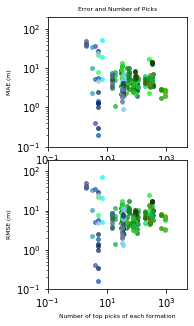

In [31]:
errors = pd.read_csv("errors.csv")
grid = plt.GridSpec(2, 1, wspace=0.4, hspace=0.1)
fig = plt.figure(figsize=(2.5, 5))
upper = plt.subplot(grid[0, :])
for formation in strat_order:
    subset = errors[errors.Formation == formation]
    upper.scatter(
        subset["n_holdout"] + subset["n_train"],
        subset["MAE"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
    upper.scatter(
        subset["n_holdout.1"] + subset["n_train.1"],
        subset["MAE.1"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
    upper.scatter(
        subset["n_holdout.2"] + subset["n_train.2"],
        subset["MAE.2"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
    up = upper.scatter(
        subset["n_holdout.3"] + subset["n_train.3"],
        subset["MAE.3"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
upper.semilogx()
upper.semilogy()
upper.set_ylabel("MAE (m)", fontsize=6)
upper.set_title("Error and Number of Picks", fontsize=6)

#upper.set_xticklabels(
#    [10 ** -2, 10 ** -1, 10 ** 1, 10 ** 3], fontsize=6,
#)
#upper.set_yticklabels([10 ^ -1, 10 ** 0, 10 ** 1, 10 ** 2], fontsize=6)
upper.set_xlim(0.1, 5000)
upper.set_ylim(0.1, 200)


lower = plt.subplot(grid[1, :])

for formation in strat_order:
    subset = errors[errors.Formation == formation]
    lower.scatter(
        subset["n_holdout"] + subset["n_train"],
        subset["RMSE"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
    lower.scatter(
        subset["n_holdout.1"] + subset["n_train.1"],
        subset["RMSE.1"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
    lower.scatter(
        subset["n_holdout.2"] + subset["n_train.2"],
        subset["RMSE.2"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
    lo = lower.scatter(
        subset["n_holdout.3"] + subset["n_train.3"],
        subset["RMSE.3"],
        color=colors_to_plot[str(formation)],
        alpha=0.75,
        s=15,
    )
lower.semilogx()
lower.semilogy()
lower.set_xlabel("Number of top picks of each formation", fontsize=6)
lower.set_ylabel("RMSE (m)", fontsize=6)
#lower.set_xticklabels(
#    [10 ** -2, 10 ** -1, 10 ** 1, 10 ** 3], fontsize=6,
#)
#lower.set_yticklabels([10 ** -1, 10 ** 0, 10 ** 1, 10 ** 2], fontsize=6)
lower.set_xlim(0.1, 5000)
lower.set_ylim(0.1, 200)
plt.savefig('RMSE_formation.pdf')

# Training size and Error

In [34]:
%%capture
big_de_error = []
for ran in range(100):
    de_error = []
    for i in np.arange(0.99, 0, -0.1):
        training, testing = sample_splitter(tops, i, ran)
        print(f"Training size is {len(training)} tops, and test size is {len(testing)} tops")
        D_df = training.pivot_table("SS", "Formation", "API").fillna(
            0
        )  # pivot table to move into sparse matrix land
        R = D_df.values

        A = binarize(R)
        U, Vt = runALS(R, A, 3, 20, 0.1)
        recommendations = np.dot(U, Vt)  # get the recommendations
        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        )  # results
        newDF = recsys.T
        newDF.reset_index(inplace=True)
        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()
        new_df = pd.merge(
            testing,
            flat_preds,
            how="left",
            left_on=["API", "Formation"],
            right_on=["API", "Formation"],
        )
        new_df.rename(columns={0: "SS_pred"}, inplace=True)
        cleanDF = new_df.dropna()
        cleanDF["signed_error"] = cleanDF["SS"] - cleanDF["SS_pred"]
        #de_error.append(
        #    np.sqrt(MSE(cleanDF.SS.values - ssmin, cleanDF.SS_pred.values - ssmin))
        #)
        de_error.append(
            MAE(cleanDF.SS.values - ssmin, cleanDF.SS_pred.values - ssmin)
        )
        locationDF = cleanDF.merge(well_locs[["Northing", "Easting", "API"]], on="API")
    big_de_error.append(de_error)


for i in range(len(big_de_error)):

    plt.plot(
        np.arange(0.01, 1, 0.1),
        big_de_error[i],
        c="k",
        marker="o",
        markersize=1,
        alpha=0.1,
    )
    plt.ylim(1, 1000)
    plt.semilogy()
    #plt.ylabel("Root Mean Squared Error (m)")
    plt.ylabel("Mean Absolute Error (m)")
    plt.xlabel("Percent of dataset used to train")
    #plt.title("Root Mean Squared Error for 100 random train-test splits")
    plt.title("Mean Absolute Error for 100 random train-test splits")

    plt.savefig('size_and_error_MAE.pdf')


# Error by well

In [33]:
masterDF = pd.concat(cross_validation_wells(tops, 86, 2, 290, 0.1))
masterDF.to_csv('error_map.csv')

Validating on 1667 tops
Starting Iterations
foldno is 0
Validating on 1667 tops
Starting Iterations
foldno is 1
Validating on 1667 tops
Starting Iterations
foldno is 2
Validating on 1667 tops
Starting Iterations
foldno is 3
